# Mapping brain activation and representation with fMRI

Authors:
- Madeline Shaw
- Parker Rice
- Diego Zuniga

## Libraries

In [ ]:
pip install nilearn --quiet

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nilearn import plotting, datasets
from scipy.stats import wilcoxon
import requests
from scipy import stats
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Import Dataset

In [ ]:
# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 100

# The data have already been aggregated into ROIs from the Glasser parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in seconds

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated twice in each subject
RUNS   = ['LR','RL']
N_RUNS = 2

# There are 7 tasks. Each has a number of 'conditions'
# TIP: look inside the data folders for more fine-graned conditions

EXPERIMENTS = {
    'MOTOR'      : {'cond':['lf','rf','lh','rh','t','cue']},
    'WM'         : {'cond':['0bk_body','0bk_faces','0bk_places','0bk_tools','2bk_body','2bk_faces','2bk_places','2bk_tools']},
    'EMOTION'    : {'cond':['fear','neut']},
    'GAMBLING'   : {'cond':['loss','win']},
    'LANGUAGE'   : {'cond':['math','story']},
    'RELATIONAL' : {'cond':['match','relation']},
    'SOCIAL'     : {'cond':['ment','rnd']}
}

In [ ]:
fname = "hcp_task.tgz"
url = "https://osf.io/2y3fw/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [ ]:
# The download cells will store the data in nested directories starting here:
HCP_DIR = "./hcp_task"

# importing the "tarfile" module
import tarfile

# open file
with tarfile.open(fname) as tfile:
  # extracting file
  tfile.extractall('.')

subjects = np.loadtxt(os.path.join(HCP_DIR, 'subjects_list.txt'), dtype='str')

In [ ]:
regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    hemi=['Right']*int(N_PARCELS/2) + ['Left']*int(N_PARCELS/2),
)

## Dataset Structure

In [ ]:
#Number of Subjects
subjects = np.loadtxt(os.path.join(HCP_DIR, 'subjects_list.txt'), dtype=str)
print(f"Number of subjects: {len(subjects)}")


# 2. Number of experiments and conditions per experiment
print(f"Number of experiments: {len(EXPERIMENTS)}")
for exp, info in EXPERIMENTS.items():
    n_conds = len(info['cond'])
    print(f"  - {exp}: {n_conds} conditions")
    for cond in info['cond']:
        print(f"    - {cond}")


#Number of parcels and hemisphere split
regions = np.load(os.path.join(HCP_DIR, 'regions.npy'))
num_parcels = regions.shape[0]
half = num_parcels // 2
print(f"Number of parcels: {num_parcels}")
print(f"Parcels by hemisphere: Right = {half}, Left = {num_parcels - half}")

# 4. Runs and TR
print(f"Runs per experiment: {RUNS}")
print(f"Time resolution (TR): {TR} seconds")


Number of subjects: 100
Number of experiments: 7
  - MOTOR: 6 conditions
    - lf
    - rf
    - lh
    - rh
    - t
    - cue
  - WM: 8 conditions
    - 0bk_body
    - 0bk_faces
    - 0bk_places
    - 0bk_tools
    - 2bk_body
    - 2bk_faces
    - 2bk_places
    - 2bk_tools
  - EMOTION: 2 conditions
    - fear
    - neut
  - GAMBLING: 2 conditions
    - loss
    - win
  - LANGUAGE: 2 conditions
    - math
    - story
  - RELATIONAL: 2 conditions
    - match
    - relation
  - SOCIAL: 2 conditions
    - ment
    - rnd
Number of parcels: 360
Parcels by hemisphere: Right = 180, Left = 180
Runs per experiment: ['LR', 'RL']
Time resolution (TR): 0.72 seconds


### Pre-defined functions

In [ ]:
def load_single_timeseries(subject, experiment, run, remove_mean=True):
  """Load timeseries data for a single subject and single run.

  Args:
    subject (str):      subject ID to load
    experiment (str):   Name of experiment
    run (int):          (0 or 1)
    remove_mean (bool): If True, subtract the parcel-wise mean (typically the mean BOLD signal is not of interest)

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_run  = RUNS[run]
  bold_path = f"{HCP_DIR}/subjects/{subject}/{experiment}/tfMRI_{experiment}_{bold_run}"
  bold_file = "data.npy"
  ts = np.load(f"{bold_path}/{bold_file}")
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts


def load_evs(subject, experiment, run):
  """Load EVs (explanatory variables) data for one task experiment.

  Args:
    subject (str): subject ID to load
    experiment (str) : Name of experiment
    run (int): 0 or 1

  Returns
    evs (list of lists): A list of frames associated with each condition

  """
  frames_list = []
  task_key = f'tfMRI_{experiment}_{RUNS[run]}'
  for cond in EXPERIMENTS[experiment]['cond']:
    ev_file  = f"{HCP_DIR}/subjects/{subject}/{experiment}/{task_key}/EVs/{cond}.txt"
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev       = dict(zip(["onset", "duration", "amplitude"], ev_array))
    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)
    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)
    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
    frames_list.append(frames)

  return frames_list

In [ ]:
# Example
my_exp = 'MOTOR'
my_subj = subjects[1]
my_run = 1

data = load_single_timeseries(subject=my_subj,
                              experiment=my_exp,
                              run=my_run,
                              remove_mean=True)
print(data.shape)

(360, 284)


In [ ]:
#NMA provides an atlas. Run this cell to download it
import os, requests

# NMA provides an atlas
fname = f"{HCP_DIR}/atlas.npz"
url = "https://osf.io/j5kuc/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

with np.load(fname) as dobj:
  atlas = dict(**dobj)

 # Download fsaverage surfaces
fs = datasets.fetch_surf_fsaverage(mesh='fsaverage5')


## Initial Binary-Experiment Analysis

In [ ]:
#1. Define which experiments are binary (exactly 2 conditions)
binary_exps = [exp for exp,info in EXPERIMENTS.items() if len(info['cond']) == 2]
binary_exps = [exp for exp in binary_exps if exp != 'SOCIAL'] #Social experiment is incomplete, doesnt have information about the 2nd condition 'rnd'
print(f"Processing these binary experiments: {binary_exps}")

Processing these binary experiments: ['EMOTION', 'GAMBLING', 'LANGUAGE', 'RELATIONAL']


In [ ]:
#2. For each subject and experiment we extract their bold signals and we calculate the mean

#Initialize dictionary
subj_vals_all = {}
for exp in binary_exps:
    conds = EXPERIMENTS[exp]['cond']
    subj_vals_all[exp] = {conds[0]: [], conds[1]: []}

subj_vals_all



{'EMOTION': {'fear': [], 'neut': []},
 'GAMBLING': {'loss': [], 'win': []},
 'LANGUAGE': {'math': [], 'story': []},
 'RELATIONAL': {'match': [], 'relation': []}}

In [ ]:
#3. For each binary experiment, subject, run, and condition we extract the data
for exp in binary_exps:
    conds = EXPERIMENTS[exp]['cond']
    for subj in subjects:
        for run in range(N_RUNS):
            try:
                # Load timeseries data
                data = load_single_timeseries(subject=subj, experiment=exp, run=run, remove_mean=True)
                n_timepoints = data.shape[1]
                evs = load_evs(subject=subj, experiment=exp, run=run)

                for cond_idx, cond in enumerate(conds):
                    frames = evs[cond_idx]
                    valid_frames = []
                    for frame_set in frames:
                        valid_frame_set = [f for f in frame_set if f < n_timepoints]
                        if valid_frame_set:
                            valid_frames.append(valid_frame_set)

                    if valid_frames:
                        all_frames = np.concatenate([np.array(f) for f in valid_frames])
                        bold_signals = data[:, all_frames]

                        # Calculate mean!!!
                        mean_bold = np.mean(bold_signals, axis=1)

                        # Store the mean BOLD response for this subject, condition
                        subj_vals_all[exp][cond].append(mean_bold)
            except Exception as e:
                print(f"Error processing {subj} in {exp}, run {run}: {e}")
                continue

# Convert lists to arrays for easier analysis
for exp in binary_exps:
    conds = EXPERIMENTS[exp]['cond']
    for cond in conds:
        if subj_vals_all[exp][cond]:  # Check if there's data
            subj_vals_all[exp][cond] = np.array(subj_vals_all[exp][cond])
        else:
            print(f"Warning: No data for {exp}, condition {cond}")

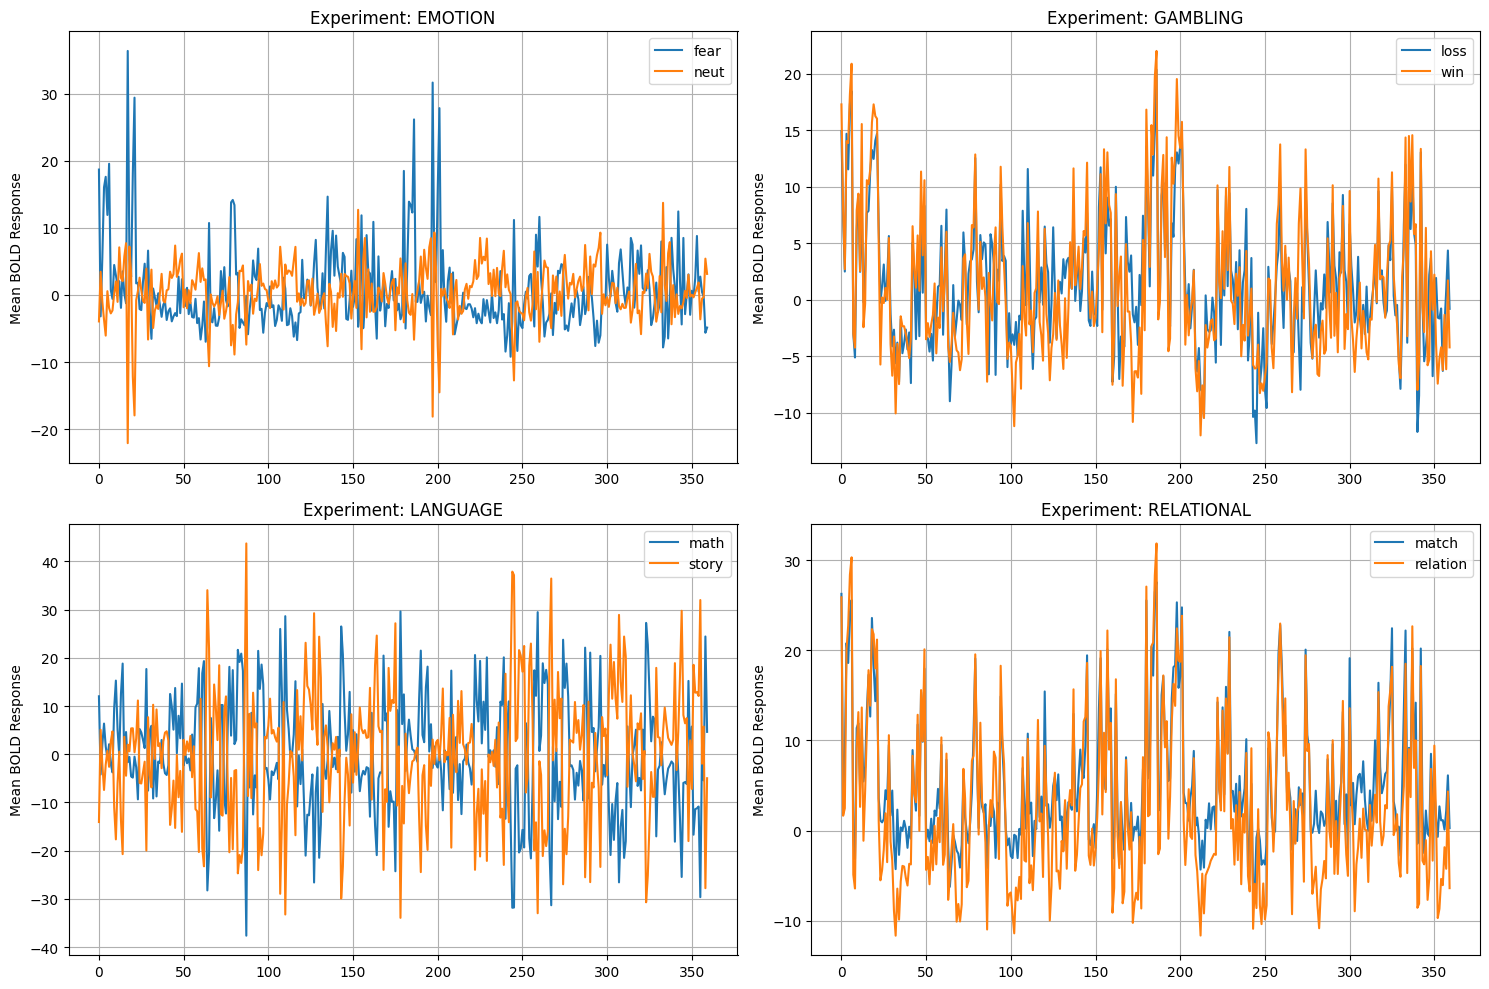

In [ ]:
#4. Plot the averaged-time-series  per each experiment-condition
plt.figure(figsize=(15, 10))

for i, exp in enumerate(binary_exps):
    conds = EXPERIMENTS[exp]['cond']

    plt.subplot(2, 2, i+1)

    # Calculate grand mean across subjects for each condition
    cond1_mean = np.mean(subj_vals_all[exp][conds[0]], axis=0)
    cond2_mean = np.mean(subj_vals_all[exp][conds[1]], axis=0)

    # Plot mean activation patterns
    plt.plot(cond1_mean, label=f"{conds[0]}")
    plt.plot(cond2_mean, label=f"{conds[1]}")

    plt.title(f"Experiment: {exp}")
    plt.ylabel("Mean BOLD Response")
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()

The mean BOLD response for the language task reveals some interesting trends regarding functional activity in the brain. For the story task we observe the largest average positive BOLD response roughly every 40-50 parcelations or roughly every 30 seconds. This aligns with the story task duration provided in the HCP Refernce Manual. The increase in BOLD response may be indicative of the transition from listening to the story to answering questions about it. Additionally, while we can't say by looking at this data alone, we may be able to associate increases and decreases in BOLD response to shifts in attention. With more data such as task performance, we could associate individual partiicpant's BOLD responses with their performance in answering story task questions correctly. This could reveal some insights regarding individual behavior during tasks such as shifts in attention throughout the duration of the task.

As for the Math task, we observe more frequent spikes of the mean BOLD signal however they are of less amplitude compared to that of the largest average BOLD spikes for the Story task. The increase in frequency aligns once again with the task protocal. Different from the Story task, the Math task required particpants to view and answer a series of questions in a span of roughly 30 seconds. The frequency of significant increase and decrease in BOLD signals may be represent the more frequent need to transition from the stimuli to answering the question.

Another idea which touches on why the amplitude of the mean BOLD response in the story task is generally higher than that of the math task relates to the need to recruit a wider variety of networks during the task. Its possible that because the story task requires the particpant to essentially hold 30 seconds worth of story information in working memory, understand it, and then make a decision, it will require a more broad usage of brain networks. The math on the other hand, which largely included simple arithmetic that was suited to competence of each participant, likely involves more of a 'reflex' like response. For young participants it may be reasonable to say that a simple addition, multiplication, etc problem can be answered with some simple memory recall alone and may not require significant activation of decision making or working memory networks.

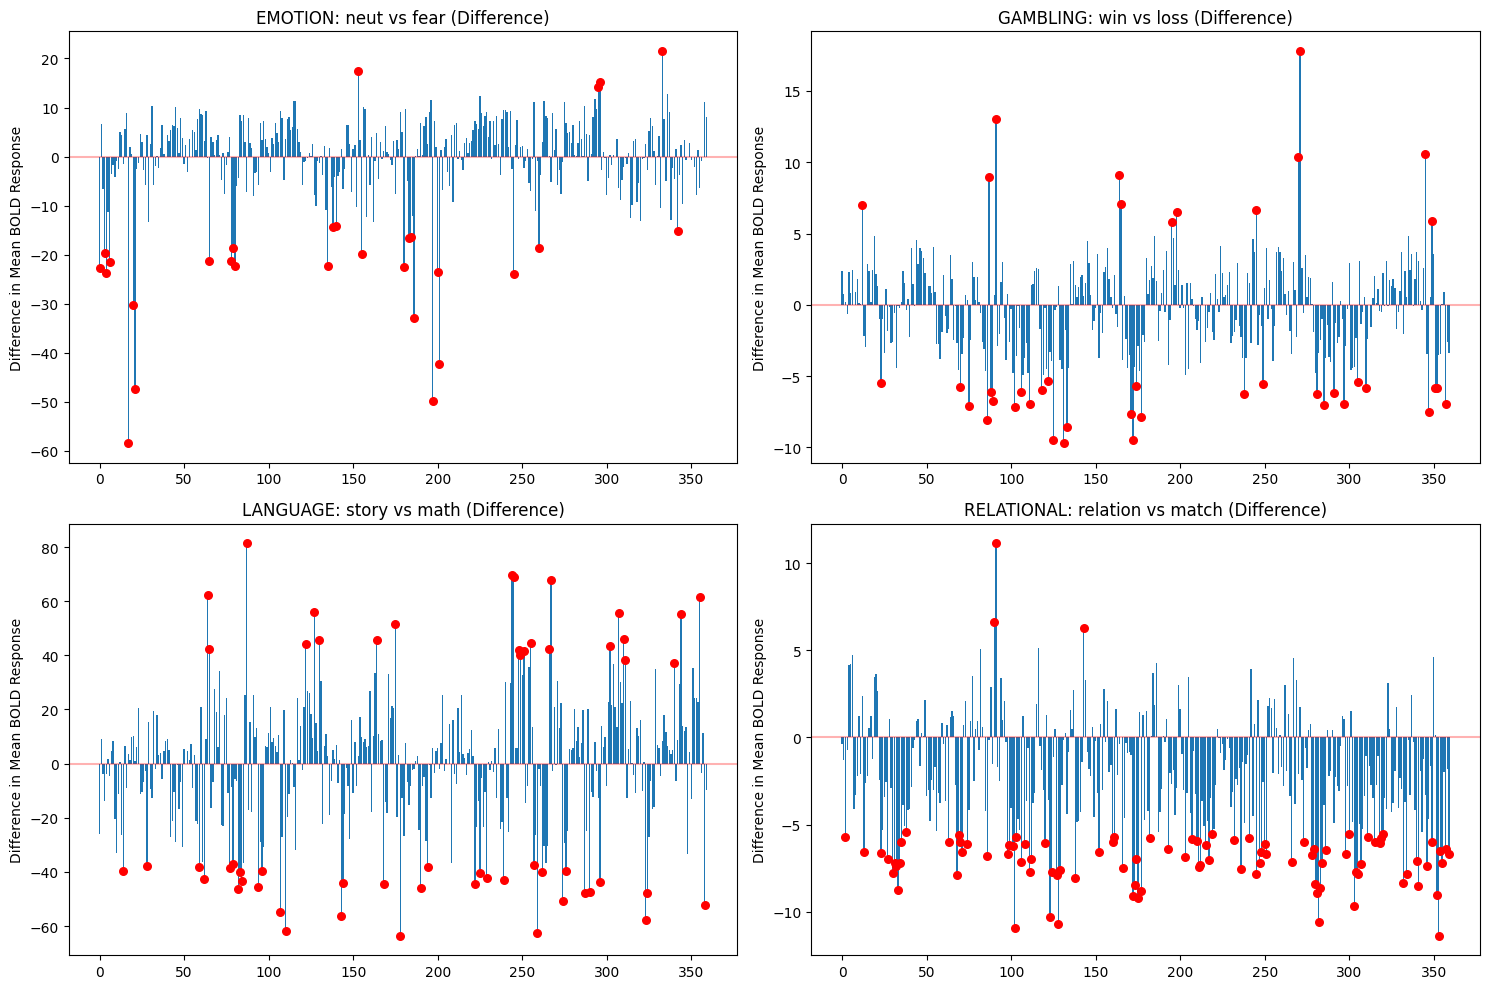

In [ ]:
#4.b Create a more detailed visualization showing the difference between conditions

plt.figure(figsize=(15, 10))
for i, exp in enumerate(binary_exps):
    conds = EXPERIMENTS[exp]['cond']

    plt.subplot(2, 2, i+1)

    cond1_mean = np.mean(subj_vals_all[exp][conds[0]], axis=0)
    cond2_mean = np.mean(subj_vals_all[exp][conds[1]], axis=0)

    # Calculate the difference between conditions
    diff = cond2_mean - cond1_mean


    plt.bar(np.arange(len(diff)), diff)
    plt.title(f"{exp}: {conds[1]} vs {conds[0]} (Difference)")
    plt.ylabel("Difference in Mean BOLD Response")
    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)

    # Highlight regions
    threshold = np.std(diff) * 1.5
    sig_parcels = np.where(np.abs(diff) > threshold)[0]
    if len(sig_parcels) > 0:
        plt.scatter(sig_parcels, diff[sig_parcels], color='red', s=30)

plt.tight_layout()
plt.show()

The difference in mean BOLD response across parcels reveals that there may be some difference in network recruitment across the brain during each task. From the plot above of the Langauage task we see that there are severeal parcels (ie. parcels ~ 60, 80, 240, 260) where the difference in mean bold response is a relatively large positive value. This suggests that each of the parcels with a large positive value denotes a much greater mean BOLD response in the story task compared to the mask task, and thus a greater recruitment of that brain region to perform the task. This leads us to believe that there is in fact a difference in network activity with respect to each task.

Similary, the parcels where the difference in mean BOLD response is a large negative value show that the corresponding brain region was on average much more active for the math task.

From this visual representation of the difference in mean BOLD response we can say that the each condition of the language tasks recruits different regions of the brain to a different degree.

In [ ]:
 #5 Statistical Testing per Experiment Between Conditions
print("\nStatistical Wilcoxon Results:")

alpha = 0.05
num_experiments = len(binary_exps)
adjusted_alpha = alpha/num_experiments

for exp in binary_exps:
    conds = EXPERIMENTS[exp]['cond']
    data_cond1 = subj_vals_all[exp][conds[0]]
    data_cond2 = subj_vals_all[exp][conds[1]]

    # Perform Wilcoxon for each parcel
    sig_parcels = 0
    p_values = []
    for parcel in range(data_cond1.shape[1]):
        stat, p = wilcoxon(data_cond1[:, parcel], data_cond2[:, parcel])
        p_values.append(p)
        if p < adjusted_alpha:
            sig_parcels += 1

    print(f"\n{exp} ({conds[0]} vs {conds[1]}):")
    print(f"Significantly different parcels: {sig_parcels}/{data_cond1.shape[1]} ({sig_parcels/data_cond1.shape[1]:.1%})")
    print(f"Median p-value: {np.median(p_values):.4f}")


Statistical Wilcoxon Results:

EMOTION (fear vs neut):
Significantly different parcels: 198/360 (55.0%)
Median p-value: 0.0051

GAMBLING (loss vs win):
Significantly different parcels: 56/360 (15.6%)
Median p-value: 0.2282

LANGUAGE (math vs story):
Significantly different parcels: 297/360 (82.5%)
Median p-value: 0.0000

RELATIONAL (match vs relation):
Significantly different parcels: 155/360 (43.1%)
Median p-value: 0.0357


We used the Wilcoxon signed-rank test to compare BOLD response distributions between experimental conditions. This non-parametric test is appropriate for paired observations (same subjects in both conditions) when we cannot assume normality.

The null hypothesis (H<sub>0</sub>) states the median difference between pairs is zero. We reject H<sub>0</sub> if p < α/number_of_tests.

Based on the Wilcoxon test:

1. **Emotion (Fear vs Neutral)**  
   - 55% of parcels showed significant differences  
   - Strong evidence of differential activation in emotional processing regions

2. **Gambling (Loss vs Win)**  
   - 15.6% significant parcels  
   - Minimal neural differentiation between loss/win outcomes

3. **Language (Math vs Story)**  
   - 82.5% significant parcels  
   - Distinct cognitive processing between analytical and narrative tasks

4. **Relational (Match vs Relation)**  
   - 43.1% significant parcels  
   - Moderate differentiation in abstract reasoning networks



**Language tasks showed the strongest neural differentiation.**

Based on the figures above as well as the Wilcoxon signed-rank test we can say that the level of the parcels, each of the language tasks is recuiting a different set of regions to a more or lesser degree.

## Language Task Analysis

### 1. Correlation Matrix Between Regions

Question: "Do brain regions show distinct functional connectivity patterns during math vs story tasks?

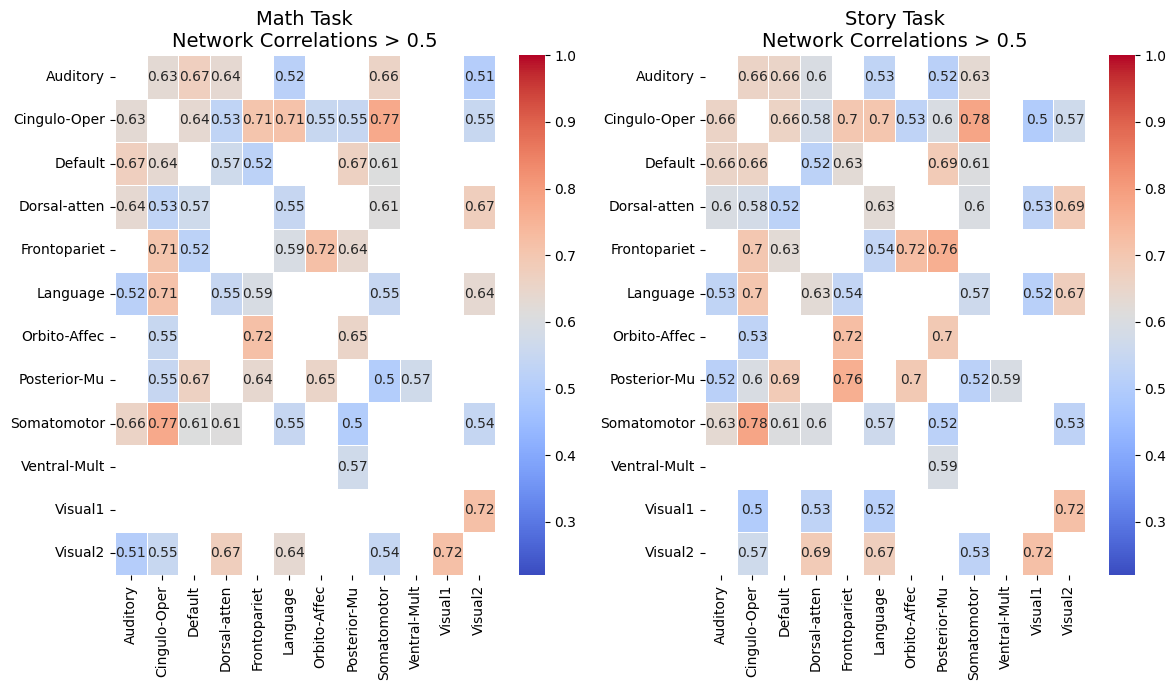

In [ ]:
#Parameters
threshold = 0.5

# Get experiment data
math_data = subj_vals_all['LANGUAGE']['math']
story_data = subj_vals_all['LANGUAGE']['story']

# Get unique networks (ignoring hemispheres)
all_networks = list(region_info['network'])
unique_networks = sorted(set(all_networks))

# Create network grouping indices
network_indices = {}
for network in unique_networks:
    network_indices[network] = [i for i, net in enumerate(all_networks) if net == network]

# Calculate Network Averages (Combined Hemispheres)
def calculate_network_averages(data):
    network_means = np.zeros((data.shape[0], len(unique_networks)))
    for subj_idx in range(data.shape[0]):
        for net_idx, network in enumerate(unique_networks):
            network_means[subj_idx, net_idx] = np.mean(data[subj_idx, network_indices[network]])
    return network_means

math_networks = calculate_network_averages(math_data)
story_networks = calculate_network_averages(story_data)

# Calculate Correlation Matrices
math_corr = np.corrcoef(math_networks.T)
story_corr = np.corrcoef(story_networks.T)


# Set statistical threshold
math_mask = (np.abs(math_corr) < threshold) | np.eye(*math_corr.shape, dtype=bool)
story_mask = (np.abs(story_corr) < threshold) | np.eye(*story_corr.shape, dtype=bool)


# Plot
plt.figure(figsize=(12, 7))
vmin = np.percentile(np.concatenate([math_corr, story_corr]), 2)
vmax = np.percentile(np.concatenate([math_corr, story_corr]), 98)

# Math Task
plt.subplot(121)
sns.heatmap(math_corr,mask=math_mask, cmap='coolwarm', vmin=vmin, vmax=vmax,
           xticklabels=unique_networks, yticklabels=unique_networks,
           annot=True, linewidths=0.5)
plt.title(f"Math Task\nNetwork Correlations > {threshold}", fontsize=14)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)

# Story Task
plt.subplot(122)
sns.heatmap(story_corr,mask=story_mask, cmap='coolwarm', vmin=vmin, vmax=vmax,
           xticklabels=unique_networks, yticklabels=unique_networks,
           annot=True, linewidths=0.5)
plt.title(f"Story Task\nNetwork Correlations > {threshold}", fontsize=14)
plt.xticks(rotation=90, fontsize=10)

cbar = plt.gcf().axes[-1].collections[0].colorbar
plt.tight_layout()
plt.show()

We computed network‐level correlation patterns for two tasks (Math vs Story).

- **Grouping Regions by network** and computing each subject's mean activation per network.
- **Builidng correlation matrices** for each task and scaling to visualize better each heatmap.
- **Defining a significance threshold** $(Ex. r=0.5)$


The correlation matrix above representions the correlation of functional activity between regions over the course of the math task (left) and the story task (right). The absolute values of the correlations have been taken and placed against a threshold of o.5 to show only the regions with a stronger leaning correlation. In comparing the matrices between the two tasks there are very similar. In most cases the difference in correlation between any two regions across the math and story tasks seldom exceeds a value of 0.05.

This leads us to believe that at the level of broad networks there is not much difference between functional connectivty in each task, in other words the networks governing performance in both the story and math tasks are not all that different. If we interpret the results of BOLD response at the parcel level alongside the functional connectivty at the network level we can say that the absolute BOLD response is highly variable between specific regions of interest (ROI's), however the way in which the networks of ROI's correlate with each other is fairly similar across both tasks.

The similar values in function correlation may also differ between tasks due to the loss in spatial resolution that occurs when going from activity at the parcel level to that of the network level. At the parcel level we have 360 parcels (180 for each hemisphere) which had been segmented by Glasser et al. in 2016. Thus in computing a functional connectivity matrix of 360 x 360 we would be able to see more clearly the way in which specific ROI's correlated with each other. Visualizing a matrix of this size however is inefficient and visually difficult to analyze compared to a 12 x12 matrix. However when grouping these parcels into just 12 networks which don't discrimiate between hemispheres we lose some of the information as the BOLD signal becomes averaged over the parcels in each network. Therefore it is important we pay close attention to the mean BOLD actiivty for each parcel and also the laterality index in order to make more definitive claims about the acitivty supporting each task.

### 2. Hemisphere Lateralization Analysis
Question: "Is there hemispheric dominance in language processing regions during math vs narrative tasks?"

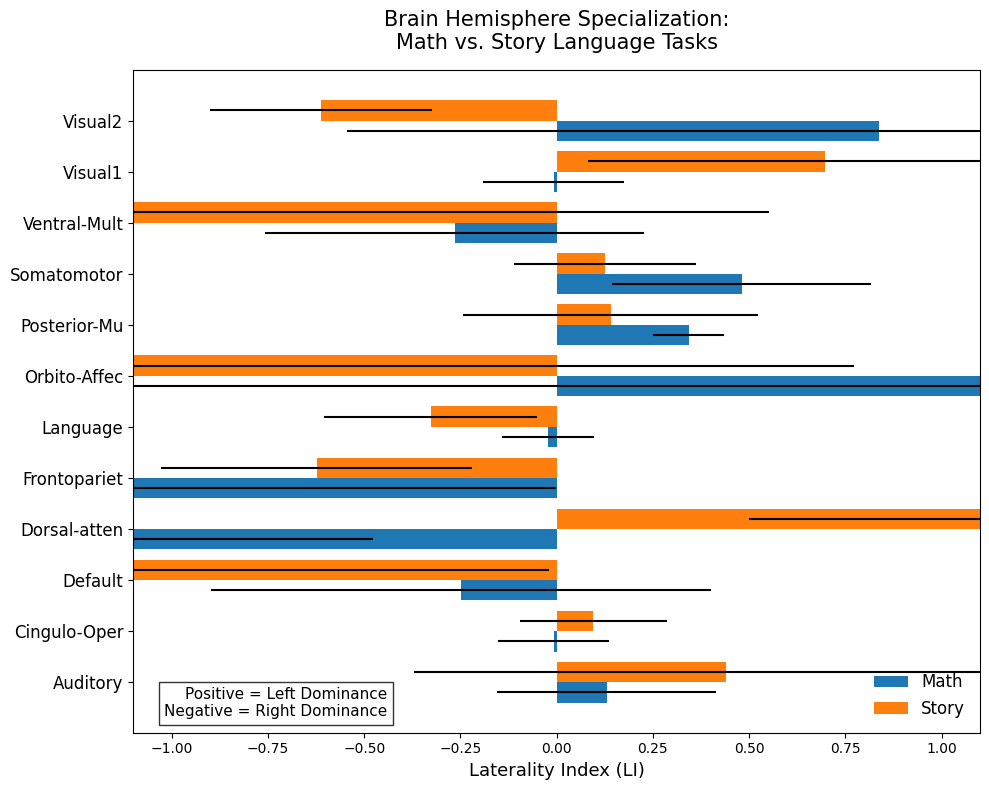

In [ ]:
networks    = region_info['network']
hemispheres = region_info['hemi']
unique_nets = sorted(set(networks))

# Precompute all subjects means per network & hemisphere

n_subj = math_data.shape[0]
n_net  = len(unique_nets)
left_idx  = {net: [i for i,(n,h) in enumerate(zip(networks, hemispheres)) if n==net and h=='Left']
             for net in unique_nets}
right_idx = {net: [i for i,(n,h) in enumerate(zip(networks, hemispheres)) if n==net and h=='Right']
             for net in unique_nets}

# Compute LI: (L − R)/(L + R + ε)
ε = 1e-6
laterality_results = []
for net in unique_nets:
    L_math  = math_data[:, left_idx[net]].mean(axis=1)
    R_math  = math_data[:, right_idx[net]].mean(axis=1)
    math_li = (L_math - R_math) / (L_math + R_math + ε)

    L_story  = story_data[:, left_idx[net]].mean(axis=1)
    R_story  = story_data[:, right_idx[net]].mean(axis=1)
    story_li = (L_story - R_story) / (L_story + R_story + ε)

    # paired t‐test
    t_stat, p_val = stats.ttest_rel(math_li, story_li)

    laterality_results.append({
        'network'    : net,
        'math_mean'  : math_li.mean(),
        'story_mean' : story_li.mean(),
        'math_sem'   : stats.sem(math_li),
        'story_sem'  : stats.sem(story_li),
        'p_value'    : p_val
    })

#Plot
fig, ax = plt.subplots(figsize=(10, 8))
y_pos    = np.arange(n_net)
bar_h    = 0.4

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
c_math, c_story = colors[0], colors[1]

for i, res in enumerate(laterality_results):
    ax.barh(y = y_pos[i] - bar_h/2,
            width = res['math_mean'],
            xerr  = res['math_sem'],
            height= bar_h,
            label = 'Math'  if i==0 else None,
            color = c_math)

    ax.barh(y = y_pos[i] + bar_h/2,
            width = res['story_mean'],
            xerr  = res['story_sem'],
            height= bar_h,
            label = 'Story' if i==0 else None,
            color = c_story)

#Format
ax.set_yticks(y_pos)
ax.set_yticklabels(unique_nets, fontsize=12)
ax.set_xlabel('Laterality Index (LI)', fontsize=13)
ax.set_title('Brain Hemisphere Specialization:\nMath vs. Story Language Tasks',
             fontsize=15, pad=15)
ax.legend(frameon=False, fontsize=12, loc='lower right')
ax.text(0.30, 0.02,
        'Positive = Left Dominance\nNegative = Right Dominance',
        transform=ax.transAxes,
        ha='right', va='bottom',
        fontsize=11,
        bbox=dict(facecolor='white', alpha=0.8))
ax.set_xlim(-1.1, 1.1)
plt.tight_layout()
plt.show()


We computed the Laterality Index (LI) for each large‐scale brain network to quantify hemispheric specialization during two tasks (Math and Story)
For each network, we:

- Identified left‐ and right‐hemisphere regions  
- Calculated subject‐wise LI as:  
  $$ \text{LI} = \frac{L - R}{L - R + \varepsilon} $$
  where \(L\) and \(R\) are the mean activations in left and right regions (and $\varepsilon=10^{-6}$) prevents division by zero)  
- Computed the mean LI and its standard error across subjects for both tasks  
- Performed a paired t-test comparing math vs. story LI  

Finally, we visualized the results with a horizontal bar plot.


The results from that laterality index allow us to explore not only the difference in the networks that govern cognition during both tasks, but it allows us to view how each network behaves with respect to each hemisphere. The initial motivation behind exploring this comes from the knowing that language in particular is among the cognitive functions that is lateralized toward the left hemisphere of the brain. This knowedlge is supported by the work done by Paul Broca and Carl Wernicke who both identified major responsiblity of left-laterilized regions for the understanding, construction and production of language. Additionally it is supported by studies such as Szaflarski et al., 2005, who found that laterization of language towards the left himsphere increases up to the age of about 25, after which the lateraliztion of language begins to diminish.

Regarding our data however, particularly that of the laterality index above, we see that language during the story task revealed a right hemisphere dominant BOLD response in Language network. While we don't have access to the specific parcels or regions that of the brain to which this network refers we can understand why this occurs despite what we have previously discussed. Left lateralization of language has been well established in the litterature and rightfully so as it primiarly focuses on comprehension and production of spoken and written language. It is also difficult to imagine a language-based or language-related task that wouldn't involve these regions, however the nuiance in our data may lie in the actual content of the specific task performed by the participants in the task.

Participants were asked to listen to roughly 30 seconds segments or stories from Aesops Fables which was immediately followed by questions on a screen in which they had to choose words that related to the story. One initial thought may be that reduced left-hemispheric lateralization during this task is partially due to the fact that participants are not speaking and were made to ansswer a question with a motor response (clicking a button). Furthermore, Aesops Fables themselves are largely known for focus on teaching morality and expression of human like emotions in animal characters. This leads us to consider the possibility that the right hemisphere of the language netork may involve identification and interpretaion of moral, emotion and metaphoric languge based scenarios. In fact several studies have revealed significant findings in tasks which showed an increase in right hemisphere activation during narrative comprehension tasks and difficulty in identifying themes or morals in those with right hemispheric damage (Youssofzadeh et al., 2022). Others have revealed the right hemispheres importance in metaphor comprehension (Coulson, Petton, 2007) and expression of emotion in prosody (Patel et al., 2018) which referes to the stress and inntonation used in speech.

While we can't make any definitive conclusions from this data regarding the role of the language network in this tasks, we can at least begin to understand why we see right-lateralization that opposes what one would generally expect from language tasks. Additionally, by exploring why the story task elicits lateralized activation of the language netowrk we can begin to understand how network activity varies between tasks and allows us to create further hypotheses on what types of task related features recruit which brain regions.

Understanding that laterlization is present throught the networks and between tasks will help us later on as we aim to classify brain activity into either the "story" or "math" task. Knowing that lateralization is present and occurs differently between each tasks means that we can reliably place more emphasis on certain network parcels in order to predict the task from activity.

In general, we wanted to know whether there was hemispheric dominance during the tasks with respect to each network and that does seem to be case for the majority of the networks. In fact the only networks that don't seem to show much lateralization of activity are the V1 network during the math task, the langauge network during the math task, the Cingulo-opercular network during both tasks. Visualizing this lateralization between networks also supports our hypothesis that the "story" and "math" tasks vary in how they recruit networks across the brain.

------------

A brief overview of other interesting patterns from the laterality index include a lateralization in the left and right hemispheres for the Primary Visual Netowrk and the Secondary Visual Network respectively. This suggests that participants might have experienced some mental imagery or visual imagination during the auditory tasks which was constructed by activity in those regions.

### 3. Machine Learning Interpretability

In [ ]:
#DataFrame for LANGUAGE
math_array = subj_vals_all['LANGUAGE']['math']
story_array = subj_vals_all['LANGUAGE']['story']
n_math = math_array.shape[0]
n_story = story_array.shape[0]

# Create column names
parcel_cols = [f'parcel_{i+1}' for i in range(math_array.shape[1])]

# Create DataFrame for math condition
df_math = pd.DataFrame(math_array, columns=parcel_cols)
df_math['condition'] = 'math'

# Create DataFrame for story condition
df_story = pd.DataFrame(story_array, columns=parcel_cols)
df_story['condition'] = 'story'

# Combine both DataFrames
df = pd.concat([df_math, df_story],ignore_index=True)


# Extract features (X) and target (y)
X = df[parcel_cols].values
y = df['condition'].map({'math': 0, 'story': 1}).values

df.head()


,parcel_1,parcel_2,parcel_3,parcel_4,parcel_5,parcel_6,parcel_7,parcel_8,parcel_9,parcel_10,...,parcel_352,parcel_353,parcel_354,parcel_355,parcel_356,parcel_357,parcel_358,parcel_359,parcel_360,condition
0,-4.950988,-13.739539,-11.362539,-8.779506,-4.960249,-9.932810,-4.563298,-8.940378,-6.308276,10.940045,...,-10.845889,-13.133631,-26.734526,-21.392545,-34.352143,-7.125167,-9.604858,15.335885,-4.784037,math
1,14.674686,-7.100107,-16.868181,6.845400,-6.625281,-6.684746,-0.015114,-0.414858,-1.211937,12.121389,...,-29.576500,14.543621,9.514504,-21.010487,-14.902001,-6.514771,5.370656,11.495480,13.605470,math
2,10.064217,-12.124782,1.702282,9.282542,-1.308735,-4.543404,8.172461,-5.696723,-8.328475,2.650407,...,-17.319719,-11.387773,-15.776622,-18.002377,-37.665704,-2.377651,-7.149141,28.351035,11.583928,math
3,12.941716,-5.726810,-3.072508,19.978246,-2.094724,2.128155,17.542074,-0.393900,-13.747918,5.710179,...,-6.646109,15.663497,-6.981757,-8.701298,-18.402084,-6.389249,9.328512,5.487546,5.369651,math
4,19.949930,-7.022271,10.828028,12.936042,12.026696,9.626061,7.107922,0.707351,3.598997,4.990627,...,-36.625679,-24.097382,-21.998915,-16.217354,-37.604151,23.057337,11.304437,36.557247,9.686903,math


We’re taking the LANGUAGE task brain‐activation maps from the math and story runs, turning each into a table of parcel values with a “math” or “story” tag, stitching them together into one dataset, and then pulling out the parcel measurements as our features (X) and the condition labels (math = 0, story = 1) as our target (y) for the classifier.

In [ ]:
#Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Initialize models to find the best
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'XGBoost': xgb.XGBClassifier(n_estimators=100, eval_metric='logloss', random_state=42)
}

# Train and evaluate models
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {acc:.4f}")


Random Forest Accuracy: 1.0000
SVM Accuracy: 0.9833
XGBoost Accuracy: 0.9917


We split our parcel‐activation data into a 70/30 train/test split—using `stratify=y` to preserve the original math/story class balance—then apply `StandardScaler` so each ROI feature has zero mean and unit variance (crucial for better and fasterconvergence).

Next, we train three models with common settings:
1. **Random Forest** (`n_estimators=100`) for robust, ensemble‐based decisions.
2.  **SVM** to capture non‐linear boundaries and enable probability outputs.
3. **XGBoost classifier** (`n_estimators=100`, `eval_metric='logloss'`) for gradient‐boosted trees tuned to minimize classification loss.

On the held‐out data, Random Forest achieved 100% accuracy, SVM 98.3%, and XGBoost 99.2%.  


After assesing the ability of three different models to classifiy fMRI parcel data into either the 'story' or the 'math' task, we see that all three perform quite well. Random forest achieved 100% accuracy and was likely able to do so because of the variance in parcel activiation between tasks. The results from this not only answer our question of whether or not we can classify parcel data belong to one task or the other on pacel data alone. The success here reveals that despite our knowing that there is overlap in brain network activity between tasks, the difference in activity that we see between tasks is not only significant but meaningful. Next we will explore where this meaningful variation in acitivty comes from and what parcels it belongs to.

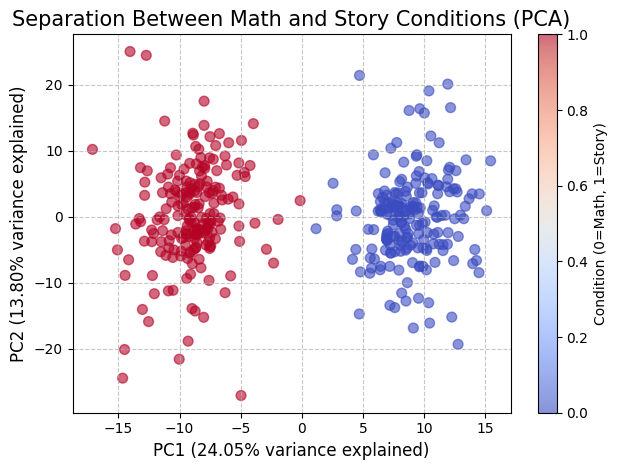

In [ ]:
#Scaled our data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', alpha=0.6, s=50)
plt.title("Separation Between Math and Story Conditions (PCA)", fontsize=15)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.2%} variance explained)", fontsize=12)
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.2%} variance explained)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.colorbar(scatter, label='Condition (0=Math, 1=Story)')
plt.tight_layout()
plt.show()

After standardizing the parcel activations we applied PCA, a dimensionality‑reduction technique that compresses our high‑dimensional parcel data into a 2 key components. This clear two‑cluster structure explains why even a simple classifier can achieve near‑perfect accuracy.  


The effectivness acheived by PCA in reducing the dimensionality of our data while retaining a significant variance is promising support the signficant difference in network activty between the two tasks.

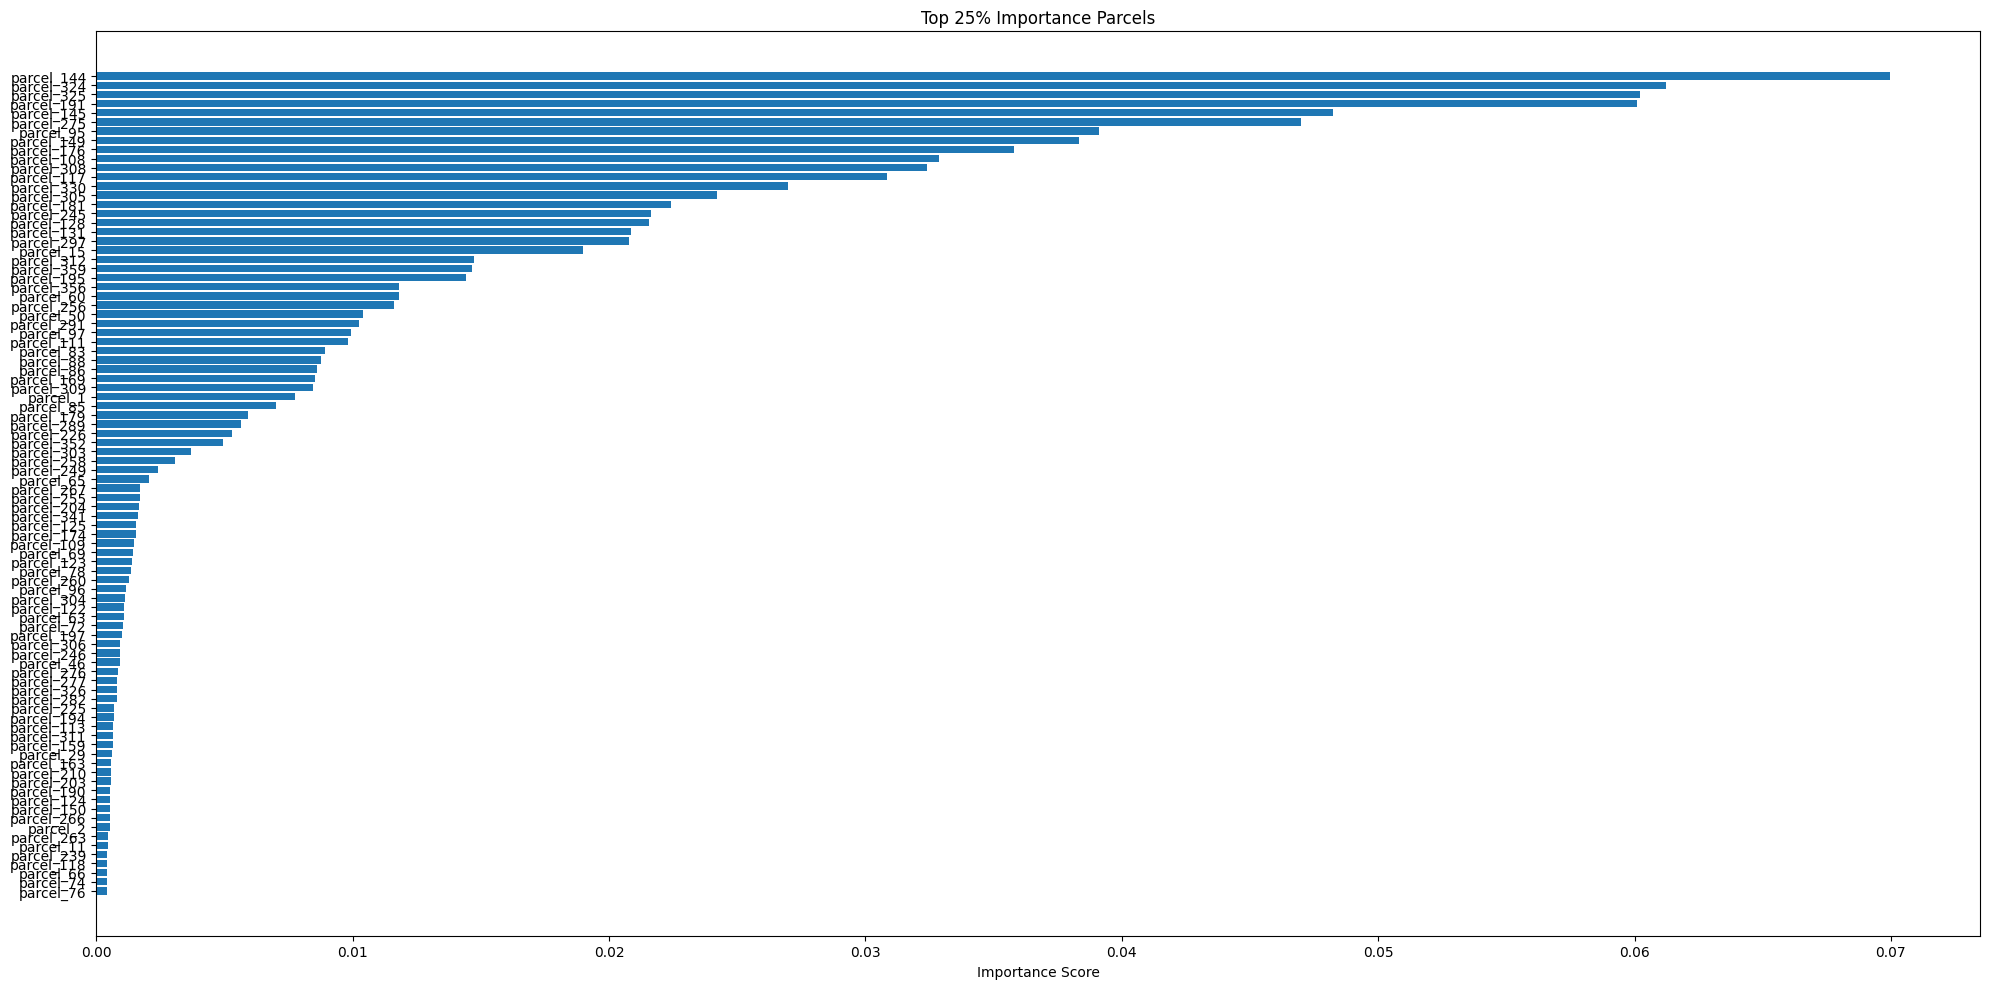

In [ ]:
#Extract Parcels that are most important to our model

top = 25 #We extract the n% most important parcels

#Choose our best model
best_model = models['Random Forest']

importances = best_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': parcel_cols, 'Importance': importances})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Select top 20% features
top_n = int(len(feature_importance_df) * top/100)
top_features = feature_importance_df.iloc[:top_n]


plt.figure(figsize=(20, 10))
plt.title(f"Top {top}% Importance Parcels")
plt.barh(top_features['Feature'][::-1], top_features['Importance'][::-1], align='center')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

Here we select our best performance model (Random Forest) to see which brain parcels drove its perfect separation of math vs. story. We take each parcel’s feature‐importance score, rank them, and pull out the top 25% most predictive parcels.

The above graph shows the important score of the top 25% mos timportant parcels as computed from our random forest model. Even within the top 25% there is a large difference in important between the most important parcela and least important one. It is these parcels that are responsible for the large amount of variability we see in network activity between each task.

Although we can't say for sure which specific brain regions or even networks each of the parcels belongs to we can note some interesting observations from this visualization. Firstly, we have a total of 360 parcels, that is 180 for eahc hemisphere. We notice that even just in the top 20 or so values of the top25% most important parcels there is a fair amount of parcels with a label above and below 180. We don't know which parcels belong to which hemisphere but these results indicate that each hemisphere contains several parcels with vary greatly in activity between the two tasks. This also may explain to large differnece in laterality between networks in each task which we saw before.

After considering that the most predictive parcels fall within the top 10-15% of all parcels we can adjust our understanding of what may be happening at the level of networks. Before we had made the claim the the 'story' and 'math' tasks are recruiting different networks across the brain and while this still may be the case we should acknowledge that we are seeing from the visualization above is that most of the importance from our predicitive model is narrowed down to just a fraction of the total parcels. While it may be true that the majority of parcels are expressing a significant difference in activity between each task, there are a handful of parcels where this difference in activty is actually so great that it allows us to differentiate, with 100% acrruacy, between which task the participant is doing.

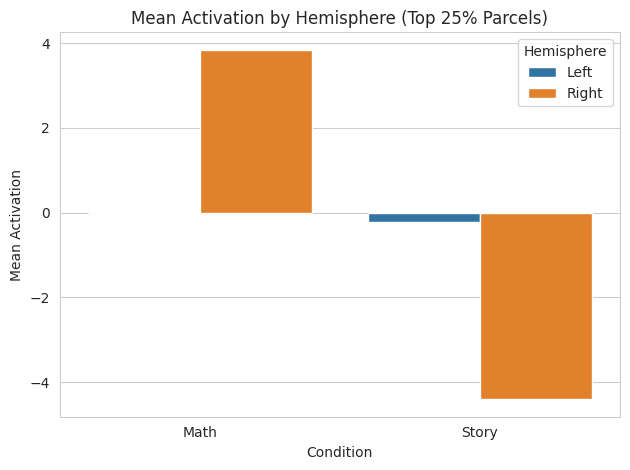

In [ ]:
#Extract the Most Important Parcels identified by our ML Model
top_indices = top_features["Feature"].str.extract(r'(\d+)').iloc[:, 0].astype(int)-1

# Prepare Hemispheres and Networks for these top parcels
top_hemis = [region_info['hemi'][i]    for i in top_indices]
top_nets  = [region_info['network'][i] for i in top_indices]


# Compute per‑subject mean activation for each hemisphere & condition
math_data  = subj_vals_all['LANGUAGE']['math']
story_data = subj_vals_all['LANGUAGE']['story']
hemis_labels = ['Left', 'Right']

rows = []
for condition, data in [('Math', math_data), ('Story', story_data)]:
    for hemi in hemis_labels:
        cols = [i for i, h in zip(top_indices, top_hemis) if h == hemi]
        subj_means = data[:, cols].mean(axis=1)
        rows.append({
            'Condition': condition,
            'Hemisphere': hemi,
            'MeanActivation': subj_means.mean()
        })

df_hemi = pd.DataFrame(rows)

# Plot hemisphere activations per state
sns.set_style("whitegrid")
ax = sns.barplot(
    data=df_hemi,
    x='Condition',
    y='MeanActivation',
    hue='Hemisphere')
ax.set_title(f'Mean Activation by Hemisphere (Top {top}% Parcels)')
ax.set_ylabel('Mean Activation')
plt.tight_layout()
plt.show()


We pull out the top 25% most important parcels, look up which hemisphere (left/right) each belongs to, and then compute each subject’s average activation in those parcels separately for math and story runs. Finally, we plot the mean activation by hemisphere. We identify whether the left or right hemisphere contributes more strongly to distinguishing math vs. story.


The figure above allows us to visualize activation of just the top 25% most important parcels alone and their relation to hemispheric recruitment in each task. These parcels that really define the difference in localized acitivty between tasks reveal that in the math condition they are almost entirely in the right hemisphere. For the store condition however these parcels are still in the right hemisphere however their activation is negative. This difference in hemispheric activation among the top 25% of parcels highlights not only where they are in the brain but also that their activation is opposite across tasks. These results are what we hoped to see as it confirms different recruiment of these parcels specifically by each task.

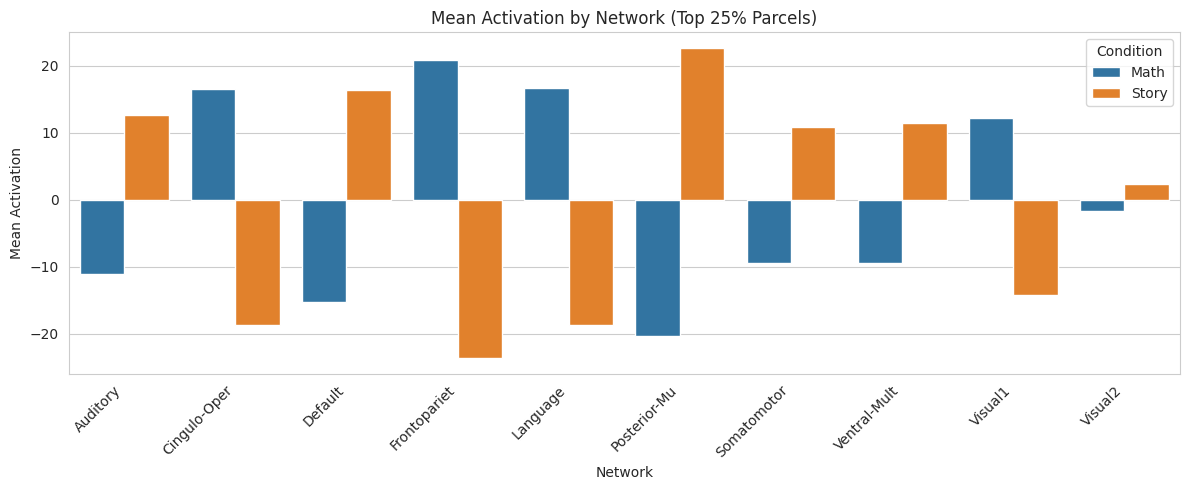

In [ ]:
# Compute per‑subject mean activation for each network & condition
unique_nets = sorted(set(top_nets))
rows = []
for condition, data in [('Math', math_data), ('Story', story_data)]:
    for net in unique_nets:
        cols = [i for i, n in zip(top_indices, top_nets) if n == net]
        subj_means = data[:, cols].mean(axis=1)
        rows.append({
            'Condition': condition,
            'Network': net,
            'MeanActivation': subj_means.mean()
        })

df_net = pd.DataFrame(rows)

# Plot network activations per state
plt.figure(figsize=(12, 5))
ax = sns.barplot(
    data=df_net,
    x='Network',
    y='MeanActivation',
    hue='Condition')
ax.set_title(f'Mean Activation by Network (Top {top}% Parcels)')
ax.set_ylabel('Mean Activation')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Here, we group our top 25% parcels by their functional network, compute each subject’s average activation within those networks for math vs. story runs, and then plot the mean activation by network. We identify the brain networks carry the strongest task‑specific signals.  


The figure above simply shows us that the top 25% most important parcels are largely responsible for the polarized variance in activity throughout each network between tasks. From this figure we can make some simple statements about the activity of the parcels as well as the networks they belong to.

The parcels associated with the auditory network were much more active in story task as we would expect given the auditory aspect.

For the cingulo-opercular netowrk it is difficult to make any assumptions about the activity other than the important parcels were much more active during the math task. The cingulo-opercular netowrk is responsible for a wide range of task-control related functions including attention, detecting errors and mainting cognitive control.

The default mode network is often active during times of passive rest and has been linked to theory of mind among other things. Its possible that these parcels are more active in the story task due to 30 seconds of somewhat passive activity that is occuring as opposed to the math task which involved many questinos in a shorter period of time. Additionally, theory of mind relates to the thnking of others beliefs, perspectives, and emotions; something we may expect to be occuring in the mind of participants when listing to the stories on morality.

The frontoparietal network is another case in which it is difficult to make assumptions regarding the parcels activity. However, he frontoparietal network is known have a relationship which is anti correlated with that of the DMN. That is to say that it is mostly actived in 'active' states rather than 'passive' ones. This is supported by the fact that its activation follows a behavior which is opposite to that of the DMN. THE FPN carries out a large number of functions including goal driven behavior, problem solving, working memory related functions. Perhaps for the participants the question associated with the story task were not very difficult or didn't require many cognitive resources associted with problem solving. Another possibility may be that the passive collection of information during a longer period of time (30 seconds) allowed participants to respond more easily. On the contrary, the math task may have recruited this region due to the participants need to quickly understand and respond to difficult math questions. It seems the difference here may relate to the spontaneity of the question being asked.

The language task as we discussed before shows activity opposite of what one would typically expect to see, but this difference may be attributed to the content of the narratives themselves.

The posterior multimodal network exhibits one of the larger differences in activation across the tasks in the top 25% parcels. It showed much greater activation during the story task which we would expect given what we know about its function. The PMN has been assocated with event cognition, social cognition, integration of sensory information, and semantic processing. All for of these components were necssary in performing the story task but not the math.

The somatomotor and ventral multimodal networks both deal with integration of information with somatomotor relating more to motor functions and the VMN more so with semantic information.

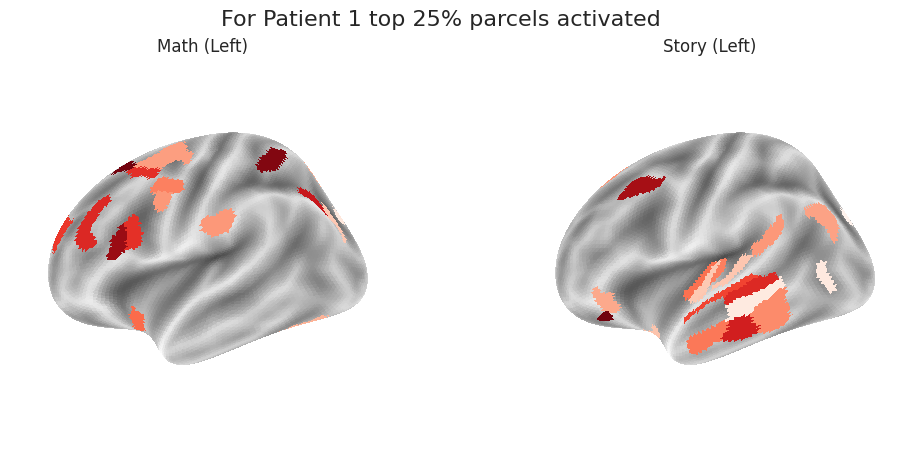

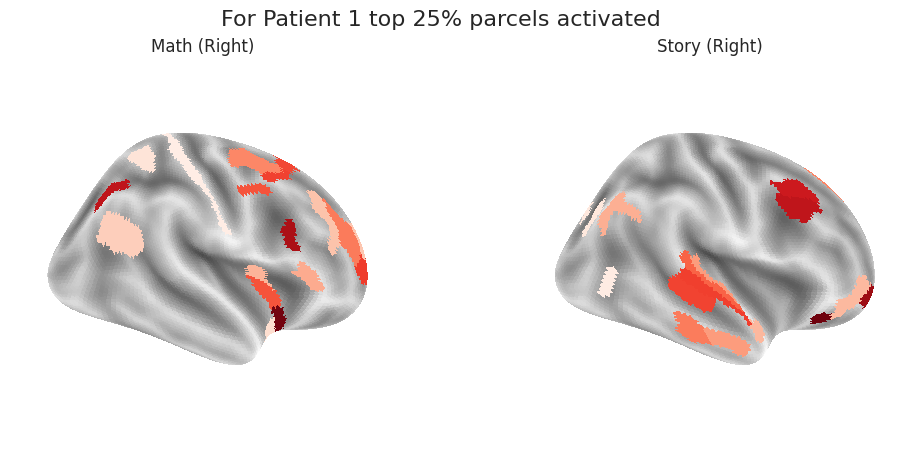

In [ ]:
# Parameters
subj_idx = 0

# Get per-parcel activations for subj_idx = 0
math_vals = subj_vals_all['LANGUAGE']['math'][subj_idx]
story_vals = subj_vals_all['LANGUAGE']['story'][subj_idx]

# Initialize vertex-wise stat maps
stat_map_L_math = np.zeros_like(atlas['labels_L'], dtype=float)
stat_map_R_math = np.zeros_like(atlas['labels_R'], dtype=float)
stat_map_L_story = np.zeros_like(atlas['labels_L'], dtype=float)
stat_map_R_story = np.zeros_like(atlas['labels_R'], dtype=float)

# Fill in vertices for each top parcel
for idx in top_indices:
    label = idx + 1
    m_val = max(0, math_vals[idx])
    s_val = max(0, story_vals[idx])
    maskL = atlas['labels_L'] == label
    maskR = atlas['labels_R'] == label
    stat_map_L_math[maskL] = m_val
    stat_map_R_math[maskR] = m_val
    stat_map_L_story[maskL] = s_val
    stat_map_R_story[maskR] = s_val

# Revised plotting helper for hemisphere-focused plots
def plot_hemisphere(surf_mesh, sulc, stat_math, stat_story, hemi_name):
    fig, axes = plt.subplots(1, 2, subplot_kw={'projection': '3d'}, figsize=(12, 5))

    # Plot Math condition
    plotting.plot_surf_roi(
        surf_mesh=surf_mesh,
        roi_map=stat_math,
        hemi=hemi_name,
        view='lateral',
        bg_map=sulc,
        cmap='Reds',
        title=f'Math ({hemi_name.capitalize()})',
        axes=axes[0],
        vmin=0
    )

    # Plot Story condition
    plotting.plot_surf_roi(
        surf_mesh=surf_mesh,
        roi_map=stat_story,
        hemi=hemi_name,
        view='lateral',
        bg_map=sulc,
        cmap='Reds',
        title=f'Story ({hemi_name.capitalize()})',
        axes=axes[1],
        vmin=0
    )

    plt.suptitle(f'For Patient {subj_idx+1} top {top}% parcels activated', fontsize=16)
    plt.show()

# Plot left hemisphere (both conditions)
plot_hemisphere(
    surf_mesh=fs['infl_left'],
    sulc=fs['sulc_left'],
    stat_math=stat_map_L_math,
    stat_story=stat_map_L_story,
    hemi_name='left'
)

# Plot right hemisphere (both conditions)
plot_hemisphere(
    surf_mesh=fs['infl_right'],
    sulc=fs['sulc_right'],
    stat_math=stat_map_R_math,
    stat_story=stat_map_R_story,
    hemi_name='right'
)

For a single subject, we pull their parcel activations (based on our ML Model) for math and story, map each parcel’s BOLD value onto the cortical mesh (left and right separately), and then render lateral surface plots side‑by‑side for math and story. This gives a vertex‑wise visualization of where the top parcels light up on each hemisphere under each condition.  


*Possible* Questions:
1. Difference in functional activity of regions between story and math task.
2. Difference in functional activity between regions of each hemisphere during each task.
3. We know from the task description that the stimuli portion of the story task lasts about 30 seconds. After this time the participant is forced to answer questions relating to the story. We can see if the average functional connectivity patterns are different for times when the stimuli is present compared to when the participant is answering the question. From this we may be able to make inferences about the networks that are active during language-task based decision making and possibly working memory.
4. Similarly for the math task, the task in total lasts about 30 seconds however this period of time alternated between presenting the particpant with a math questions and then the particpant choosing the correct answer afterwards. We may be able to look at how the functional connectivity matrix changes throughout the duration of the task. This may also indicate transitions in activity between problem solving regions.
